# Tutorial on the use of a Pairwise Model for Community Prediction

This notebook will walk you through the steps of making predictions of community composition using pairwise equilibrium data and the model published in Gjini \& Madec, 2021: https://www.biorxiv.org/content/10.1101/2021.01.17.426995v1.abstract.

Imports:

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sb

Import of this module

In [2]:
from predict_by_model import *

## Part 1: Prediction of c. diff engraftment in mice.

In part 1 of this tutorial, we will predict c. diff engraftment on mice for which we have 16s community data. Community data is given as a .csv file called *Cdif_mice_high_vs_low_risk.species.tsv* whose columns correspond to mice and rows correspond to taxa, and entries corresponding to read counts.

To do this, we will use the predictions of pairwise metabolic modeling with resource allocation constraints as "observed" pairwise experiments. These "observations" can be found in *Pairwise_Chemostat.xlsx*.

For this data, we require a function to parse the taxa labels into something that matches our pairwise equilibrium data.

In [3]:
def GetStrn(strg):
    s1 = strg.split(";")[-1]
    s2 = "_".join(s1.split("__")[1:])
    return s2

We create a directory to store the output of the prediction:

In [4]:
dirname = "Tutorial"
try:
    os.mkdir(dirname)
except:
    pass

Next we load and parse the communities we wish to predict on, 

In [5]:
miceData = pd.read_csv("Cdiff_mice_high_vs_low_risk.species.tsv",sep = '\t')
Experiments = miceData.columns[np.where(['WK' in colnm for colnm in miceData.columns])]
species = miceData.species.apply(GetStrn)

and create a pandas DataFrame object to store the results.

In [6]:
predictions = pd.DataFrame(index =  Experiments, columns = ["Invasion","CDiffDelta","Resistance","CDiffResistance","CDiffPromotion","InitialCDiffGrowth","SpeciesFound","SpeciesListed","ReadProportion"])

To make our predictions, we must provide a set of "observed" equilibrium relative abundances from pairwise growth experiments. This file should have rows \& columns corresponding to taxa, and include all taxa present in the communities, if possible. The module will attempt to match the taxa names from the community data file (miceData) to these labels, and will return the number found and the proportion of reads covered by those found.

In [7]:
ObservationFile =  "Pairwise_Chemostat.xlsx" #This should be an excel file with a sheet labeled "Relative_Abundance"

The main function uses an *Experiment* object which has the attributes "Community" and "Invader". The community should be a list of community members (e.g. parsed rows of miceData with number of reads above some threshhold), and invader the name of a invading taxa.

Here, we trim the communities by read proportion over 0.1\%

In [8]:
for exp in Experiments:

    by_proportion = miceData[exp]/sum(miceData[exp])
    spec_list = list(species[by_proportion>0.001])
    by_proportion.index = species

    experiment = Experiment()
    experiment.Community = spec_list
    experiment.Invader = "Clostridium_difficile"
    invName,invSuc,zt,t,Qt,InvaderQ,r0,foundlist = predict_by_model(experiment,File = ObservationFile,lambdaVersion = "Equilibrium", verb = True)


    cddelta = (zt.T[-1][-1] - zt.T[-1][0])/zt.T[-1][0]
    found = len(foundlist)
    total = len(spec_list)
    biomass = sum(by_proportion[np.unique(foundlist)])
    predictions.loc[exp] = [invSuc,cddelta,Qt,InvaderQ,r0 + InvaderQ,r0,found,total,biomass]

Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostridia_bacterium_UC5.1-1D1 not found
[Ruminococcus]_torques not found
[Clostridium]_celerecrescens not found
Erysipelatoclostridium_ramosum not found
Found 19/29 community members.
Computing Community Equilibrium
Simulating Invasion
Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostridia_bacterium_UC5.1-1D1 not found
[Ruminococcus]_torques not found
[Clostridium]_celerecrescens not found
Erysipelatoclostridium_ramosum not found
Found 18/28 community members.
Computing Community Equilibrium
Simulating Invasion
Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostri

For visualization, we'll add a column for the risk information contained in the mice labels.

In [9]:
predictions["CDiffRisk"] = [r[0] for r in predictions.index]

And view the results:

In [10]:
predictions

,Invasion,CDiffDelta,Resistance,CDiffResistance,CDiffPromotion,InitialCDiffGrowth,SpeciesFound,SpeciesListed,ReadProportion,CDiffRisk
H1_4WK,True,96.294841,0.982405,0.987814,1.998125,1.01031,20,29,0.897664,H
H2_4WK,True,91.591102,0.982251,0.988,2.005117,1.017117,19,28,0.847712,H
H3_4WK,True,96.294841,0.982405,0.987814,1.998125,1.01031,20,29,0.899252,H
H4_4WK,True,91.203921,0.982366,0.988072,1.997601,1.009529,19,28,0.895981,H
H5_4WK,True,91.594518,0.982213,0.987963,2.005178,1.017216,19,29,0.866974,H
H6_4WK,True,86.478974,0.982211,0.988292,2.004531,1.016239,18,28,0.894308,H
L1_4WK,False,-1.0,1.000346,0.999559,0.740366,-0.259193,33,49,0.907811,L
L2_4WK,False,-1.0,1.00037,0.99953,0.739398,-0.260132,31,47,0.892905,L
L3_4WK,False,-1.0,1.000334,0.999656,0.762777,-0.236879,35,48,0.909158,L
L4_4WK,False,-1.0,1.000378,0.999612,0.739622,-0.25999,34,50,0.90651,L


Save the results as a csv:

In [11]:
predictions.to_csv(dirname + "/micePredictionEqFit.csv")

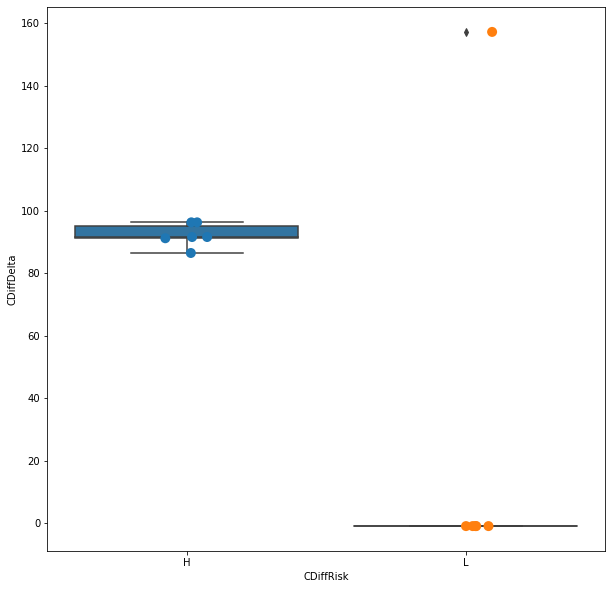

In [12]:
fig,ax = plt.subplots(figsize = (10,10))
sb.stripplot(x = "CDiffRisk", y = "CDiffDelta",data = predictions, s=10, ax = ax)
sb.boxplot(x = "CDiffRisk", y = "CDiffDelta",data = predictions,ax =ax)
fig.savefig(dirname + "/tutorialDelta.png")

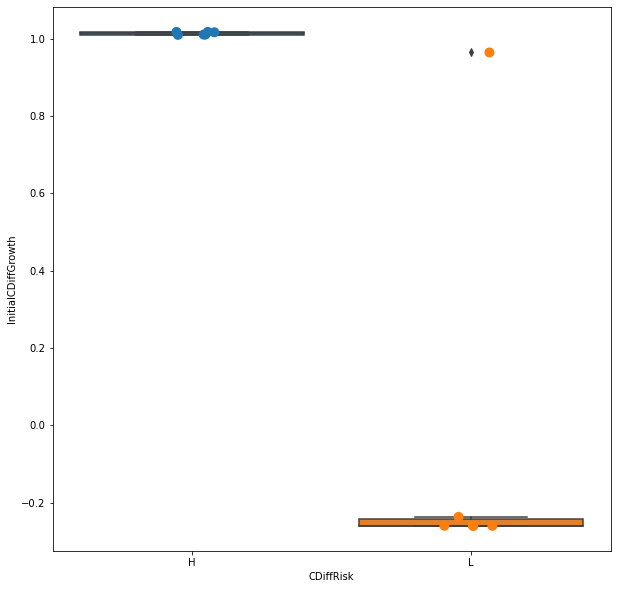

In [13]:
fig,ax = plt.subplots(figsize = (10,10))
sb.stripplot(x = "CDiffRisk", y = "InitialCDiffGrowth",data = predictions, s=10, ax = ax)
sb.boxplot(x = "CDiffRisk", y = "InitialCDiffGrowth",data = predictions,ax =ax)
fig.savefig(dirname + "/tutorialinitialgrowth.png")

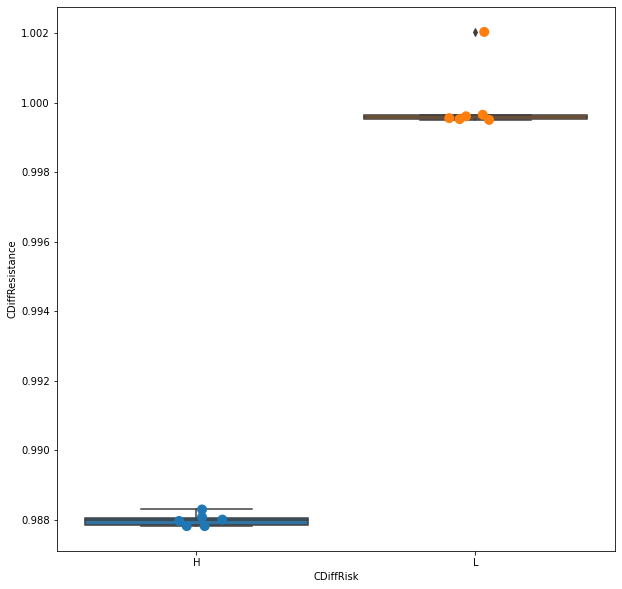

In [14]:
fig,ax = plt.subplots(figsize = (10,10))
sb.stripplot(x = "CDiffRisk", y = "CDiffResistance",data = predictions, s=10, ax = ax)
sb.boxplot(x = "CDiffRisk", y = "CDiffResistance",data = predictions,ax =ax)
fig.savefig(dirname + "/tutorialresistance.png")

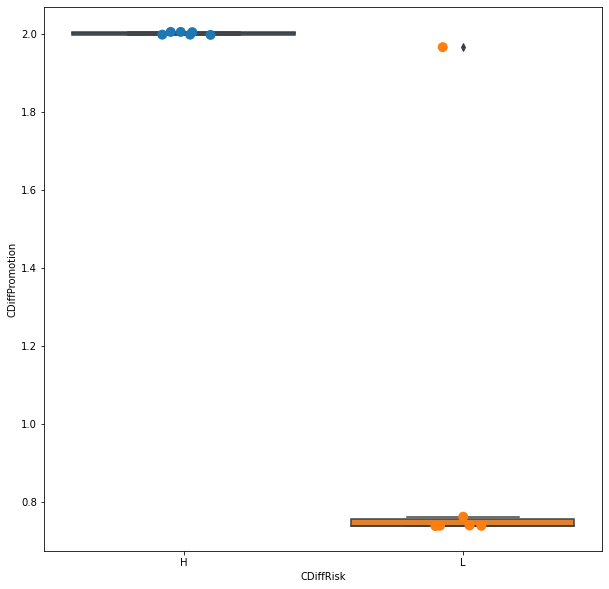

In [15]:
fig,ax = plt.subplots(figsize = (10,10))
sb.stripplot(x = "CDiffRisk", y = "CDiffPromotion",data = predictions, s=10, ax = ax)
sb.boxplot(x = "CDiffRisk", y = "CDiffPromotion",data = predictions,ax =ax)
fig.savefig(dirname + "/tutorialpromotion.png")

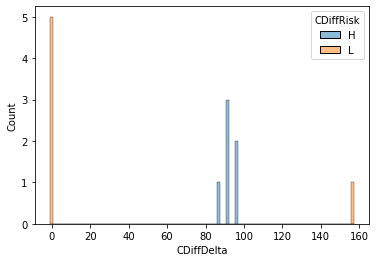

In [16]:
fig,ax = plt.subplots()
sb.histplot(x ="CDiffDelta",hue = "CDiffRisk",data = predictions, ax = ax,bins = 100)
fig.savefig(dirname + "/tutorialdeltaHistogram.png")

## Part 2: Prediction of Community Equilibrium

It is simple to predict only the community equilibrium (assuming the community settles at one), without an invader. In fact, this is done in the above so that the invader is introduced at community equilibrium.

In [76]:
CommunityEquilibrium = {}
FoundLists = {}
observed_communities = {}
for exp in Experiments:

    by_proportion = miceData[exp]/sum(miceData[exp])
    spec_list = list(species[by_proportion>0.001])
    by_proportion.index = species

    Equilibrium,FoundList = predict_community(spec_list,File = ObservationFile,lambdaVersion = "Equilibrium", verb = True)

    CommunityEquilibrium[exp] = dict([(ky,val.round(3)) for ky,val in Equilibrium.items()])
    FoundLists[exp] = FoundList
    observed_communities[exp] = by_proportion[np.unique(FoundList)][~by_proportion[np.unique(FoundList)].index.duplicated()]

Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostridia_bacterium_UC5.1-1D1 not found
[Ruminococcus]_torques not found
[Clostridium]_celerecrescens not found
Erysipelatoclostridium_ramosum not found
Found 19/29 community members.
Computing Community Equilibrium
Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostridia_bacterium_UC5.1-1D1 not found
[Ruminococcus]_torques not found
[Clostridium]_celerecrescens not found
Erysipelatoclostridium_ramosum not found
Found 18/28 community members.
Computing Community Equilibrium
Generating Lambdas
Bacteroides_salanitronis not found
Barnesiella_viscericola not found
Prevotella_buccalis not found
Prevotella_sp._109 not found
Alistipes_obesi not found
Clostridia_bacterium_UC5.1-1D1 not found
[Rumin

In [60]:
CommunityEquilibrium["H1_4WK"]

{"'Bacteroides_cellulosilyticus_DSM_14838.mat'": 0.016,
 "'Bacteroides_coprocola_M16_DSM_17136.mat'": 0.003,
 "'Bacteroides_coprophilus_DSM_18228.mat'": 0.047,
 "'Bacteroides_fluxus_YIT_12057.mat'": 0.065,
 "'Bacteroides_oleiciplenus_YIT_12058.mat'": 0.013,
 "'Bacteroides_ovatus_ATCC_8483.mat'": 0.23,
 "'Bacteroides_plebeius_M12_DSM_17135.mat'": 0.0,
 "'Bacteroides_salyersiae_WAL_10018.mat'": 0.305,
 "'Bacteroides_stercoris_ATCC_43183.mat'": 0.0,
 "'Bacteroides_thetaiotaomicron_VPI_5482.mat'": -0.0,
 "'Bacteroides_uniformis_ATCC_8492.mat'": 0.0,
 "'Bacteroides_vulgatus_ATCC_8482.mat'": 0.322,
 "'Bifidobacterium_animalis_lactis_AD011.mat'": 0.0,
 "'Enterococcus_faecalis_OG1RF_ATCC_47077.mat'": 0.0,
 "'Flavonifractor_plautii_ATCC_29863.mat'": 0.0,
 "'Lactobacillus_plantarum_JDM1.mat'": 0.0,
 "'Odoribacter_laneus_YIT_12061.mat'": -0.0,
 "'Parabacteroides_distasonis_ATCC_8503.mat'": 0.0,
 "'Parabacteroides_johnsonii_DSM_18315.mat'": 0.0}

[Text(0, 0, "'Bacteroides_cellulosilyticus_DSM_14838.mat'"),
 Text(1, 0, "'Bacteroides_coprocola_M16_DSM_17136.mat'"),
 Text(2, 0, "'Bacteroides_coprophilus_DSM_18228.mat'"),
 Text(3, 0, "'Bacteroides_fluxus_YIT_12057.mat'"),
 Text(4, 0, "'Bacteroides_oleiciplenus_YIT_12058.mat'"),
 Text(5, 0, "'Bacteroides_ovatus_ATCC_8483.mat'"),
 Text(6, 0, "'Bacteroides_plebeius_M12_DSM_17135.mat'"),
 Text(7, 0, "'Bacteroides_salyersiae_WAL_10018.mat'"),
 Text(8, 0, "'Bacteroides_stercoris_ATCC_43183.mat'"),
 Text(9, 0, "'Bacteroides_thetaiotaomicron_VPI_5482.mat'"),
 Text(10, 0, "'Bacteroides_uniformis_ATCC_8492.mat'"),
 Text(11, 0, "'Bacteroides_vulgatus_ATCC_8482.mat'"),
 Text(12, 0, "'Bifidobacterium_animalis_lactis_AD011.mat'"),
 Text(13, 0, "'Enterococcus_faecalis_OG1RF_ATCC_47077.mat'"),
 Text(14, 0, "'Flavonifractor_plautii_ATCC_29863.mat'"),
 Text(15, 0, "'Lactobacillus_plantarum_JDM1.mat'"),
 Text(16, 0, "'Odoribacter_laneus_YIT_12061.mat'"),
 Text(17, 0, "'Parabacteroides_distasonis_ATCC

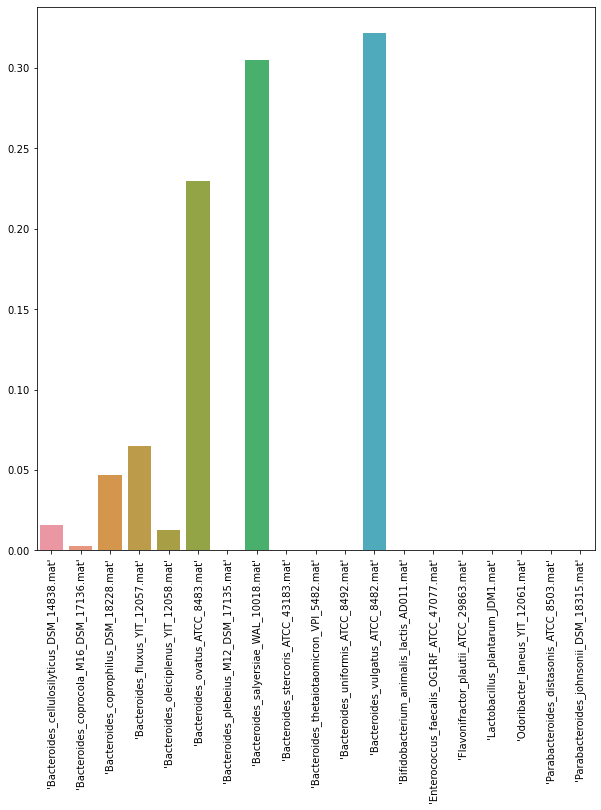

In [79]:
fig,ax = plt.subplots(figsize = (10,10))

keys = list(CommunityEquilibrium["H1_4WK"].keys())
# get values in the same order as keys, and parse percentage values
vals = [float(CommunityEquilibrium["H1_4WK"][k]) for k in keys]
sb.barplot(x=keys, y=vals, ax = ax)
ax.set_xticklabels(keys, rotation = 90)

[Text(0, 0, 'Bacteroides_cellulosilyticus'),
 Text(1, 0, 'Bacteroides_coprocola'),
 Text(2, 0, 'Bacteroides_coprophilus'),
 Text(3, 0, 'Bacteroides_fluxus'),
 Text(4, 0, 'Bacteroides_oleiciplenus'),
 Text(5, 0, 'Bacteroides_ovatus'),
 Text(6, 0, 'Bacteroides_plebeius'),
 Text(7, 0, 'Bacteroides_salyersiae'),
 Text(8, 0, 'Bacteroides_stercoris'),
 Text(9, 0, 'Bacteroides_thetaiotaomicron'),
 Text(10, 0, 'Bacteroides_uniformis'),
 Text(11, 0, 'Bacteroides_vulgatus'),
 Text(12, 0, 'Bifidobacterium_animalis'),
 Text(13, 0, 'Enterococcus_faecalis'),
 Text(14, 0, 'Flavonifractor_plautii'),
 Text(15, 0, 'Lactobacillus_plantarum'),
 Text(16, 0, 'Odoribacter_laneus'),
 Text(17, 0, 'Parabacteroides_distasonis'),
 Text(18, 0, 'Parabacteroides_johnsonii')]

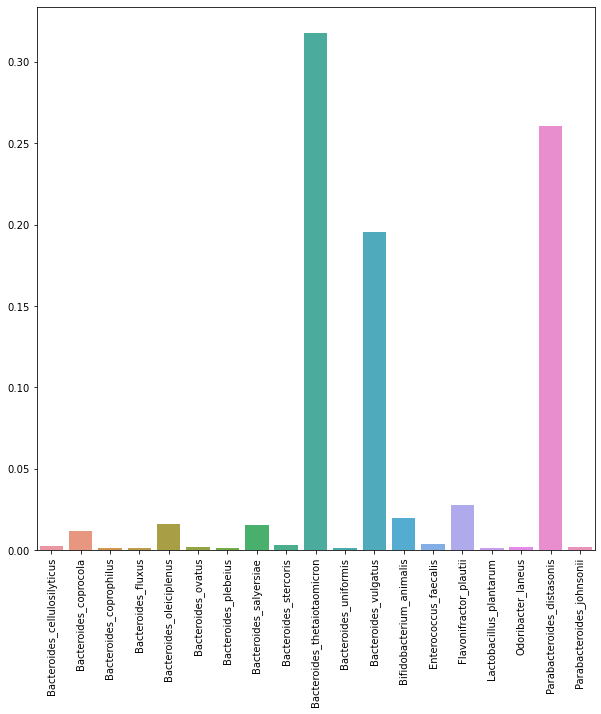

In [78]:
fig,ax = plt.subplots(figsize = (10,10))

keys = list(observed_communities["H1_4WK"].index)
# get values in the same order as keys, and parse percentage values
vals = [observed_communities["H1_4WK"].loc[k] for k in keys]
sb.barplot(x=keys, y=vals, ax = ax)
ax.set_xticklabels(keys, rotation = 90)